# Treat and plot the datas form the ATR

Here is the study of the datas from the ATR42 (french aircraft) during the Hymex campaign which aim at studying the heavy precipitation events in the Mediterranean region. The plane flight multiple times, each time an event was announced. 

### Observing strategy:
see Ducrocq et al (2014): HyMeX-SOP1, the field campaign dedicated to heavy precipitation and flash flooding in the northwestern Mediterranean. Bulletin of the American Meteorological Society, 95, 1083-1100. https://doi.org/10.1175/BAMS-D-12-00244.1(Supplementary materials: 10.1175_bams-d-12-00244.2.pdf)

### Instruments: 
- **FMPS**: Aerosol in situ particle size distribution [ 10nm-500nm diameter] 107 channels.
    - electric mobility equivalent diameter

- **OPC** : Aerosol in situ particle size distribution [ 0.25 - 10 microns diameter] 32 channels. (0.25 - 2.5 microns 16 channels)
    - Optical Particle Counter.
    - Optical equivalent diameter
 
- **CCNC**: cloud condensation nuclei counter :
    - concentration on activable particles at 0.3% surtaturation

- **CPC** : Condensation Particle Counter


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
import cartopy
import matplotlib as mpl 
import re
import pandas as pd
import os 

# Get the default color cycle

default_cycler = plt.rcParams['axes.prop_cycle']
default_colors = default_cycler.by_key()['color']


# Load the data for one flight
path = '/home/lenobler/Data/HYMEX/Aerosol/'
OPC = xr.load_dataset(path + 'OPC/OPCgrimm_HYMEX_ATR42_as120051_20121018_V3.nc')
CCNC = xr.load_dataset(path + 'CCNC/CCNC_HYMEX_ATR42_as120051_20121018_V3.nc')
FMPS = xr.load_dataset(path + 'FMPS/FMPS_HYMEX_ATR42_as120051_20121018_V3.nc')
CPC = xr.load_dataset(path + 'CPC/CPC_HYMEX_ATR42_as120051_20121018_V3.nc')

## Routine for plotting

In [3]:
def plot_towns(ax, lats, lons, resolution='10m', transform=ccrs.PlateCarree(), zorder=3):
    """
    This function will download the 'populated_places' shapefile from
    NaturalEarth, trim the shapefile based on the limits of the provided
    lat & long coords, and then plot the locations and names of the towns
    on a given GeoAxes.
    
    ax = a pyplot axes object
    lats = list of 2 values [min, max]
    lons = list of 2 values [min, max]
    resolution= str. either high res:'10m' or low res: '50m'
    transform = a cartopy crs object
    """
    import pandas as pd
    import cartopy.io.shapereader as shpreader
    import cartopy.crs as ccrs

    #get town locations
    shp_fn = shpreader.natural_earth(resolution=resolution, category='cultural', name='populated_places')
    shp = shpreader.Reader(shp_fn)
    xy = [pt.coords[0] for pt in shp.geometries()]
    x, y = list(zip(*xy))

    #get town names
    towns = shp.records()
    names_en = []
    for town in towns:
        names = town.attributes['NAME']
        names_en.append(names)

    #create data frame and index by the region of the plot
    all_towns = pd.DataFrame({'names_en': names_en, 'x':x, 'y':y})
    region_towns = all_towns[(all_towns.y<lats[1]) & (all_towns.y>lats[0])
                           & (all_towns.x>lons[0]) & (all_towns.x<lons[1])]

    #plot the locations and labels of the towns in the region
    ax.scatter(region_towns.x.values, region_towns.y.values, c ='black', marker= '.', transform=transform, zorder=zorder)
    transform_mpl = ccrs.PlateCarree()._as_mpl_transform(ax) #this is a work-around to transform xy coords in ax.annotate
    for i, txt in enumerate(region_towns.names_en):
         ax.annotate(txt[:3], (region_towns.x.values[i], region_towns.y.values[i]), xycoords=transform_mpl)




from cartopy.io.img_tiles import GoogleTiles

class ShadedReliefESRI(GoogleTiles):
    # shaded relief
    def _image_url(self, tile):
        x, y, z = tile
        url = ('https://server.arcgisonline.com/ArcGIS/rest/services/' \
               'World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg').format(
               z=z, y=y, x=x)
        return url

## Plot plane trajectory

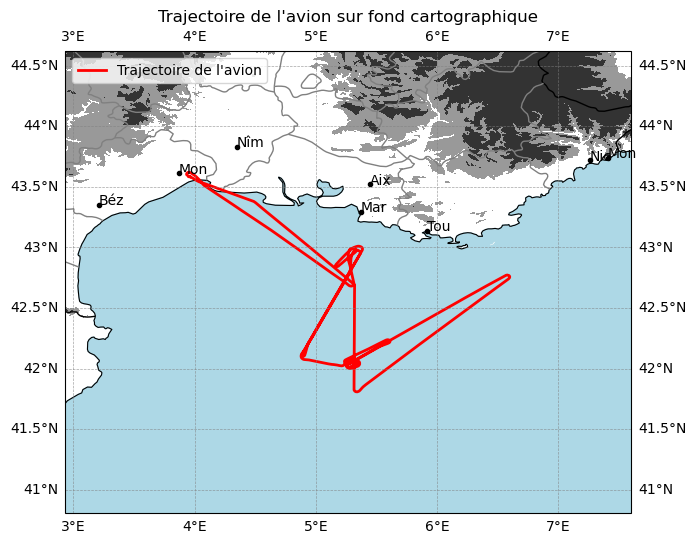

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth
import rasterio
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

# https://topotools.cr.usgs.gov/gmted_viewer/index.html
raster_file = '/home/lenobler/Data/map/GMTED_Hymex/usgs_gmted2010_30arcsec_mean_stat_cyCILiBSxkm6oLKRS5iy.tiff'

with rasterio.open(raster_file) as src:
    # Read the data and metadata
    raster_data = src.read(1)  # Reading the first band
    extent = src.bounds  # Bounds of the raster in geographical coordinates

# Extraire les coordonnées GPS
latitudes = OPC['latitude_gps'].values
longitudes = OPC['longitude_gps'].values

# Configurer la projection cartographique
projection = ccrs.PlateCarree()  # Projection Plate Carrée adaptée pour les coordonnées GPS
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

# Define the levels and colormap
# Create a custom colormap
colors = [(1, 1, 1), (0.2, 0.2, 0.2)]  # RGB for white and dark grey
cmap = mcolors.LinearSegmentedColormap.from_list("white_to_grey", colors, N=3)
norm = plt.Normalize(vmin=0, vmax=1500)

# Plot the raster data
img = ax.imshow(raster_data, origin='upper', extent=[extent.left, extent.right, extent.bottom, extent.top],
                transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)


stt_prv = cfeature.NaturalEarthFeature(category='cultural', 
    name='admin_1_states_provinces_lines',
    scale='10m',facecolor='none')

# Ajouter les traits de côtes
ax.coastlines(resolution='10m', color='black', linewidth=0.8)  # Résolution fine pour les côtes
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1)  # Ajouter les frontières
# ax.add_feature(cfeature.LAND, color='lightgrey')  # Ajouter la terre
ax.add_feature(cfeature.OCEAN, color='lightblue', zorder=0)  # Ajouter l'océan
ax.add_feature(stt_prv, edgecolor='gray')


# Tracer la trajectoire de l'avion
ax.plot(longitudes, latitudes, color='red', linewidth=2, label='Trajectoire de l\'avion', transform=ccrs.PlateCarree())

# Ajouter les valeurs sur les axes x et y
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')

# Ajouter des labels et une légende
ax.set_title("Trajectoire de l'avion sur fond cartographique")
ax.legend(loc='upper left')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Ajuster les limites de la carte si nécessaire

ax.set_extent([longitudes.min()-1, longitudes.max()+1, latitudes.min()-1, latitudes.max()+1], crs=ccrs.PlateCarree())
plot_towns(ax, ax.get_ylim(), ax.get_xlim(), resolution='10m', transform=ccrs.PlateCarree(), zorder=3)

# Afficher la carte
plt.show()


## Reample the data
Each instrument has its own frequency of aquisition. To compare them properly, we need to resample to the same date

In [5]:
import xarray as xr
import pandas as pd

def add_time_coordinate(dataset):
    """
    Combines 'ut_year', 'ut_month', 'ut_day', 'ut_hour', 'ut_minute', and 'ut_second'
    fields from an xarray dataset into a datetime coordinate.

    Parameters:
        dataset (xarray.Dataset): The input dataset containing time components.

    Returns:
        xarray.Dataset: The updated dataset with a new 'time' coordinate.
    """
    # Extract the components
    years = dataset['ut_year'].values
    months = dataset['ut_month'].values
    days = dataset['ut_day'].values
    hours = dataset['ut_hour'].values
    minutes = dataset['ut_minute'].values
    seconds = dataset['ut_second'].values

    # Combine them into datetime objects
    times = pd.to_datetime({
        "year": years,
        "month": months,
        "day": days,
        "hour": hours,
        "minute": minutes,
        "second": seconds
    })

    # Add the 'time' as a coordinate to the dataset
    dataset = dataset.assign_coords(time=("time", times))

    return dataset

def remove_non_monotonic_time(dataset):
    time = dataset.coords['time']
    # Convert time values to numerical values (e.g., Unix timestamp or float)
    time_as_float = time.astype('datetime64[s]').astype(float)

    # Find where the time is not monotonically increasing
    diff_time = np.diff(time_as_float)
    drop_indices = time[np.where(diff_time < 0)[0] + 1]  # Indices where time decreases
    
    if len(drop_indices) > 0:
        # Drop those indices from the dataset
        dataset = dataset.drop_sel(time=drop_indices)

    return dataset

In [26]:
OPC_resample = add_time_coordinate(OPC)
OPC_resample = OPC_resample.resample(time='10s').mean()

FMPS_resample = add_time_coordinate(FMPS)
FMPS_resample = FMPS_resample.resample(time='10s').mean()

CPC_resample = add_time_coordinate(CPC)
CPC_resample = CPC_resample.resample(time='10s').mean()

CCNC_resample = add_time_coordinate(CCNC)
CCNC_resample = CCNC_resample.resample(time='10s').mean()

## Now merge all the dataset

In [27]:
# rename variables to be sure of the name
excluded_vars = {'ut_year', 'ut_month', 'ut_day', 'ut_hour', 'ut_minute', 'ut_second', 'time', 'latitude_gps', 'longitude_gps', 'altitude'}

OPC_resample = OPC_resample.rename({var: f"OPC_{var}" for var in OPC_resample.variables if var not in excluded_vars})
CCNC_resample = CCNC_resample.rename({var: f"CCNC_{var}" for var in CCNC_resample.variables if var not in excluded_vars})
FMPS_resample = FMPS_resample.rename({var: f"FMPS_{var}" for var in FMPS_resample.variables if var not in excluded_vars})
CPC_resample = CPC_resample.rename({var: f"CPC_{var}" for var in CPC_resample.variables if var not in excluded_vars})

# create one only xarray dataset for all datas
aligned_datasets = xr.align(*[OPC_resample, CCNC_resample, FMPS_resample, CPC_resample], join="inner")
data = xr.merge(aligned_datasets, compat='override')

# Now, plot the datas

## Global trajectory: altitude

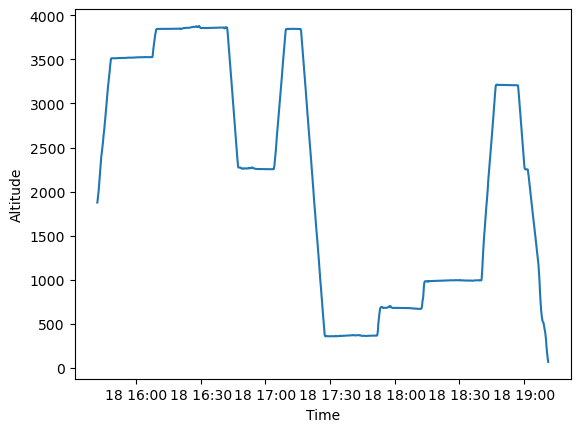

In [20]:
plt.plot(data['time'], data['altitude'])
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.show()

## Compare the two instrument for the Aerosols spectrum

There is a gap in the spectrum between the two instruments that I would like to investigate more. I do not know if it is linked with the calibrations or if it is normal 

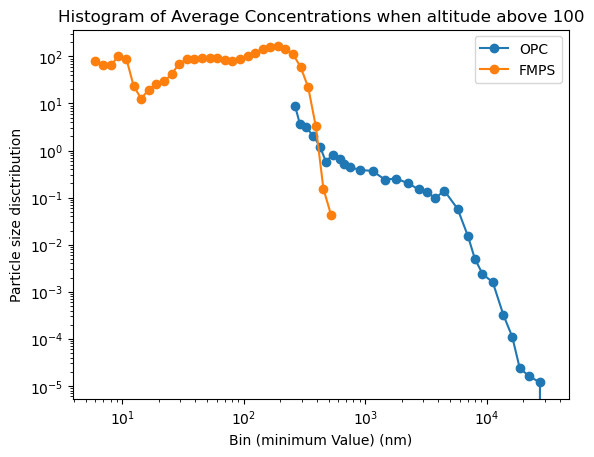

In [ ]:
import re

# FMPS datas
# Extract variable names that match the pattern
pattern = r'FMPS_concentration_channel_(\d+\.\d+)_nm'
bin_vars_FMPS = [var for var in data.data_vars if re.match(pattern, var)]

# Parse bin min values and sort
bins = [float(re.search(pattern, var).group(1)) for var in bin_vars_FMPS]
sorted_indices = np.argsort(bins)
plot_FMPS = np.array(bins)[sorted_indices]
bin_vars_FMPS = np.array(bin_vars_FMPS)[sorted_indices]


# GET OPC data
pattern = r'OPC_concentration_channel_(\d+\.\d+)_(\d+\.\d+)_microns'
bin_vars_OPC = [var for var in data.data_vars if re.match(pattern, var)]

# Parse bin min values and sort
bin_1 = np.array([float(re.search(pattern, var).group(1)) for var in bin_vars_OPC])
bin_2 = np.array([float(re.search(pattern, var).group(2)) for var in bin_vars_OPC])
plot_OPC = (bin_1+bin_2)/2 *1e3



altitude_threshold = 100  # Be sure to take the same values

# Find the times when the altitude is above the threshold
times_above_threshold = data['altitude'] > altitude_threshold
time_period = data['time'].sel(time=times_above_threshold)
data_selected = data.sel(time=time_period)

# Compute averages for the selected time period
bin_averages_FMPS = [data[var].mean(dim="time").values for var in bin_vars_FMPS]
bin_averages_OPC = [data[var].mean(dim="time").values for var in bin_vars_OPC]



# Plot the histogram
plt.plot(plot_OPC, bin_averages_OPC, marker='o', linestyle='-', label='OPC')
# plt.plot(bin_averages_OPC, bin_averages_OPC * bin_averages_FMPS[-1] / bin_averages_OPC[6], alpha=0.6, marker='o', linestyle='--', label='OPC-corrected')
plt.plot(plot_FMPS, bin_averages_FMPS, marker='o', linestyle='-', label='FMPS')



# Plot the histogram
plt.xlabel("Bin (minimum Value) (nm)")
plt.ylabel("Particle size disctribution")
plt.yscale('log')
plt.xscale('log')
plt.title(f"Histogram of Average Concentrations when altitude above {altitude_threshold}")
# plt.grid(True)
plt.legend()
plt.show()


## Aerosol spectrum versus the altitude

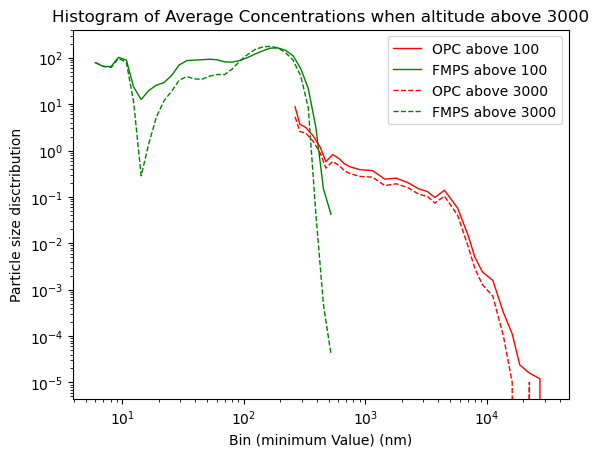

In [ ]:
import re
# from cycler import cycler

# default_cycler = (cycler(linestyle=['-', '--', ':', '-.']) * cycler(color=['r', 'g']))

# plt.rc('lines', linewidth=1)
# plt.rc('axes', prop_cycle=default_cycler)


# FMPS datas
# Extract variable names that match the pattern
pattern = r'FMPS_concentration_channel_(\d+\.\d+)_nm'
bin_vars_FMPS = [var for var in data.data_vars if re.match(pattern, var)]

# Parse bin min values and sort
bins = [float(re.search(pattern, var).group(1)) for var in bin_vars_FMPS]
sorted_indices = np.argsort(bins)
plot_FMPS = np.array(bins)[sorted_indices]
bin_vars_FMPS = np.array(bin_vars_FMPS)[sorted_indices]


# GET OPC data
pattern = r'OPC_concentration_channel_(\d+\.\d+)_(\d+\.\d+)_microns'
bin_vars_OPC = [var for var in data.data_vars if re.match(pattern, var)]

# Parse bin min values and sort
bin_1 = np.array([float(re.search(pattern, var).group(1)) for var in bin_vars_OPC])
bin_2 = np.array([float(re.search(pattern, var).group(2)) for var in bin_vars_OPC])
plot_OPC = (bin_1+bin_2)/2 *1e3



altitude_threshold = 100  # Be sure to take the same values

# Find the times when the altitude is above the threshold
times_above_threshold = data['altitude'] > altitude_threshold
time_period = data['time'].sel(time=times_above_threshold)
data_selected = data.sel(time=time_period)

# Compute averages for the selected time period
bin_averages_FMPS = [data_selected[var].mean(dim="time").values for var in bin_vars_FMPS]
bin_averages_OPC = [data_selected[var].mean(dim="time").values for var in bin_vars_OPC]

# Plot the histogram
line_OPC, = plt.plot(plot_OPC, bin_averages_OPC, label="OPC above " + str(altitude_threshold))
line_FMPS, = plt.plot(plot_FMPS, bin_averages_FMPS, label='FMPS above '+ str(altitude_threshold))


altitude_threshold = 3000  # Be sure to take the same values

# Find the times when the altitude is above the threshold
times_above_threshold = data['altitude'] > altitude_threshold
time_period = data['time'].sel(time=times_above_threshold)
data_selected = data.sel(time=time_period)

# Compute averages for the selected time period
bin_averages_FMPS = [data_selected[var].mean(dim="time").values for var in bin_vars_FMPS]
bin_averages_OPC = [data_selected[var].mean(dim="time").values for var in bin_vars_OPC]

# Plot the histogram
plt.plot(plot_OPC, bin_averages_OPC, color=line_OPC.get_color() label='OPC above '  + str(altitude_threshold))
plt.plot(plot_FMPS, bin_averages_FMPS, color=line_FMPS.get_color() label='FMPS above '  + str(altitude_threshold))



# Plot the histogram
plt.xlabel("Bin (nm)")
plt.ylabel("Particle size disctribution")
plt.yscale('log')
plt.xscale('log')
plt.title(f"Histogram of Average Concentrations when altitude above {altitude_threshold}")
# plt.grid(True)
plt.legend()
plt.show()


## Plot versus the altitude

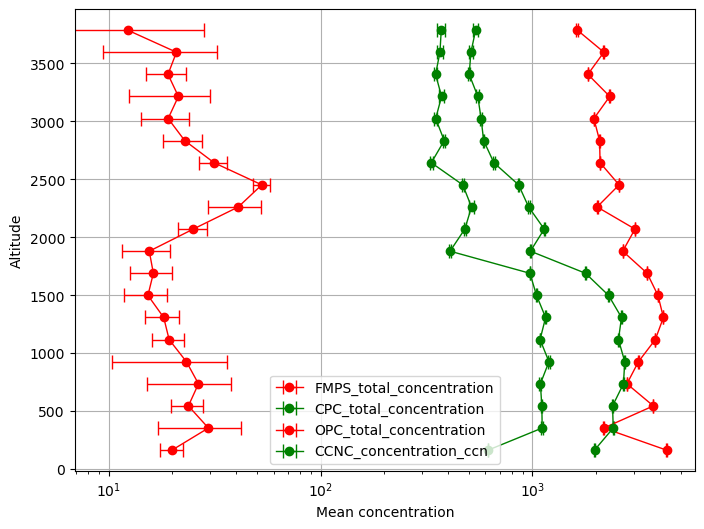

In [128]:


def plot_altitude_mean(dataset, variable):
    # Assume 'ds' is your xarray dataset
    altitude = dataset['altitude']
    fmps_concentration = dataset[variable]

    # Define altitude bins
    alt_min, alt_max = altitude.min().item(), altitude.max().item()
    num_bins = 20  # Adjust the number of bins as needed
    bins = np.linspace(alt_min, alt_max, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute bin centers for plotting

    # Digitize altitude data into bins
    bin_indices = xr.DataArray(np.digitize(altitude, bins) - 1, coords=altitude.coords)

    # Compute mean FMPS_total_concentration for each bin
    mean_concentration = np.array([
        fmps_concentration.where(bin_indices == i, drop=True).mean().item()
        if np.any(bin_indices == i) else np.nan
        for i in range(num_bins)
    ])
    # Count the number of data points in each bin
    counts = np.array([
        fmps_concentration.where(bin_indices == i).count().item()
        if (bin_indices == i).any() else 0
        for i in range(num_bins)
    ])

    # Compute Poissonian error: sqrt(N)
    poisson_error = np.sqrt(counts)

    plt.errorbar(mean_concentration, bin_centers, xerr=poisson_error, fmt='o', capsize=5, label=variable, ls='-')


# do the sum of the OPC variables
pattern = r'OPC_concentration_channel_(\d+\.\d+)_(\d+\.\d+)_microns'
list_var_OPC = [var for var in data.data_vars if re.match(pattern, var)]
data["OPC_total_concentration"] = data[list_var_OPC].to_array(dim="new_dim").sum(dim="new_dim")

# Plot the results with error bars
plt.figure(figsize=(8, 6))

plot_altitude_mean(dataset=data, variable='FMPS_total_concentration')
plot_altitude_mean(dataset=data, variable='CPC_total_concentration')
plot_altitude_mean(dataset=data, variable='OPC_total_concentration')
plot_altitude_mean(dataset=data, variable='CCNC_concentration_ccn')

plt.xlabel("Mean concentration")
plt.ylabel("Altitude")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()


## Compare CCN and CPC

We expect a strong correlation bewteen the two. I check what is the impact of altitude

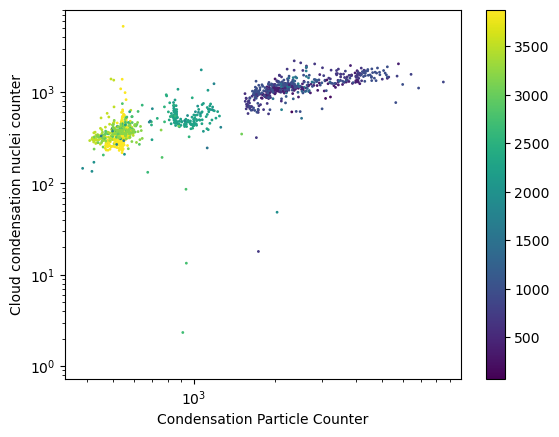

In [75]:
plt.scatter(data['CPC_total_concentration'], data['CCNC_concentration_ccn'], s=1, c=data['altitude'])
plt.xlabel('Condensation Particle Counter')
plt.ylabel('Cloud condensation nuclei counter')
plt.yscale('log')
plt.xscale('log')
plt.colorbar()